In [166]:
import pandas as pd
import numpy as np
import yfinance as yf
import random
import seaborn as sns
import matplotlib.pyplot as plt

import helper.utils as utils
import helper.data as get
import helper.decompose as decomp

from pprint import pprint

sns.set_style('whitegrid')
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['lines.linewidth'] = 1

rs = 88

In [167]:
start_date = '2000-01-01'
end_date = '2023-08-29'

# snp_tickers = data.fetch_snp_tickers()
# snp_prices = data.fetch_stock_prices(
#     snp_tickers, start_date, end_date
# )

# snp_prices.to_csv('data/snp_prices.csv')

# -- TO UNCOMMENT -- 

In [168]:
snp_prices = pd.read_csv(
    'data/snp_prices.csv', index_col='Date', parse_dates=True
)
# -- TO DELETE --

In [169]:
random.seed(rs)

sampled_tickers = random.sample(snp_prices.columns.to_list(), 25)
sampled_prices = snp_prices[sampled_tickers].copy()

In [170]:
sampled_prices.head(3)

,LRCX,DGX,INTC,D,TRMB,ADM,PSA,WRB,ACGL,IRM,...,WHR,CINF,SYK,CSX,MSI,MCK,IBM,VTR,MRO,HIG
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,32.645256,5.614895,25.123943,7.313037,4.145833,6.514029,9.379158,1.250003,1.277778,4.220662,...,32.586334,12.533746,13.840666,1.120865,129.068756,19.448540,61.718239,1.209447,4.201050,27.316633
2000-01-04,31.229067,5.603199,23.950768,7.492869,4.072917,6.446171,9.379158,1.211541,1.270833,4.087612,...,31.334278,12.520907,13.688850,1.086899,119.431900,18.203833,59.623299,1.209447,4.038638,26.411098
2000-01-05,30.775146,5.556406,24.149309,7.696672,3.817708,6.344390,9.456454,1.192311,1.388889,3.954561,...,31.795565,12.649202,14.106344,1.109543,116.291801,18.411291,61.718239,1.190549,4.146914,25.618778


In [171]:
snp_nulls = sampled_prices.isnull().sum()
snp_nulls[snp_nulls > 0]

Series([], dtype: int64)

In [172]:
# List of economic indicators to fetch
indicators_to_fetch = [
    "GDP",       # Gross Domestic Product
    "FEDFUNDS",  # Effective Federal Funds Rate
    "UNRATE",    # Unemployment Rate
    "CIVPART",   # Labor Force Participation Rate
    "PSAVERT"    # Personal Saving Rate
]

api_key_value = '7241f282cb7ac930cf729ca9d1acb3af'

economic_data = get.fetch_economic_data(
    indicators_to_fetch, start_date, end_date, api_key_value
)

In [173]:
for indicator, data in economic_data.items():
    data = data[indicator]
    print(f'{indicator:<10} shape: {str(data.shape):<12} \
Null Values: {data.isnull().sum()}')

print(f'\nNumber of economic indicators: {len(economic_data.values())}')

GDP        shape: (94,)        Null Values: 0
FEDFUNDS   shape: (283,)       Null Values: 0
UNRATE     shape: (283,)       Null Values: 0
CIVPART    shape: (283,)       Null Values: 0
PSAVERT    shape: (283,)       Null Values: 0

Number of economic indicators: 5


In [174]:
# Check frequency for each DataFrame

freq = utils.check_data_frequency(economic_data)
pprint(freq)

{'CIVPART': 'MS',
 'FEDFUNDS': 'MS',
 'GDP': 'QS-OCT',
 'PSAVERT': 'MS',
 'UNRATE': 'MS'}


In [175]:
# Check frequency of sampled prices
utils.check_stock_frequency(sampled_prices)

No set frequency.


In [176]:
# Resample stock data to daily frequency

start_idx = sampled_prices.index.min()
end_idx = sampled_prices.index.max()

daily_date_range = pd.date_range(start_idx, end_idx, freq='D')

sampled_prices = sampled_prices.reindex(daily_date_range)
utils.check_stock_frequency(sampled_prices)

D


In [177]:
# Check nulls for stock prices

price_nulls = sampled_prices.isnull().sum()
price_pct_nulls = price_nulls / len(sampled_prices)
price_pct_nulls

LRCX    0.311147
DGX     0.311147
INTC    0.311147
D       0.311147
TRMB    0.311147
ADM     0.311147
PSA     0.311147
WRB     0.311147
ACGL    0.311147
IRM     0.311147
WFC     0.311147
NSC     0.311147
CHRW    0.311147
EG      0.311147
CAH     0.311147
WHR     0.311147
CINF    0.311147
SYK     0.311147
CSX     0.311147
MSI     0.311147
MCK     0.311147
IBM     0.311147
VTR     0.311147
MRO     0.311147
HIG     0.311147
dtype: float64

In [178]:
# Resample economic data to match stock data frequency

resamp_economic_data = {}

for indicator in economic_data.keys():
    original = economic_data[indicator]
    resamp_economic_data[indicator] = original.reindex(
        sampled_prices.index
    )

utils.check_data_frequency(resamp_economic_data)

{'GDP': 'D', 'FEDFUNDS': 'D', 'UNRATE': 'D', 'CIVPART': 'D', 'PSAVERT': 'D'}

In [179]:
# Combine economic data

economic_data_df = pd.concat(
    list(resamp_economic_data.values()),
    axis=1
)

ed_nulls = economic_data_df.isnull().sum()
ed_pct_nulls = ed_nulls / len(economic_data_df)
ed_pct_nulls

GDP         0.989235
FEDFUNDS    0.967357
UNRATE      0.967357
CIVPART     0.967357
PSAVERT     0.967357
dtype: float64

In [180]:
from helper.data import ts_train_test_split

returns = sampled_prices.pct_change()
returns.loc[returns.index.min()] = 0

X = economic_data_df
y = returns

test_size = 1/3

X_train, X_test, y_train, y_test = ts_train_test_split(
    X, y, test_size=test_size
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5760, 5), (2879, 5), (5760, 25), (2879, 25))

In [181]:
def impute(*data):
    imputed = []
    for dataset in data:
        data_imputed = dataset.interpolate('akima').ffill().bfill()
        imputed.append(data_imputed)
    return tuple(imputed)

X_train_imputed, X_test_imputed, y_train_imputed, y_test_imputed = impute(
    X_train, X_test, y_train, y_test

)

In [182]:
# Check nulls after imputation
datasets = [X_train_imputed, X_test_imputed, y_train_imputed, y_test_imputed]
dataset_names = ['X_train_imputed', 'X_test_imputed', 'y_train_imputed', 'y_test_imputed']

for name, dataset in zip(dataset_names, datasets):
    null_count = dataset.isnull().sum().sum()
    print(f'{name} Null Count:\t{null_count}')

X_train_imputed Null Count:	0
X_test_imputed Null Count:	0
y_train_imputed Null Count:	0
y_test_imputed Null Count:	0


In [183]:
pca = decomp.PCATransform(n_components=5, random_state=rs)
pca.fit(y_train_imputed)

In [184]:
train_pca = pca.transformed
train_pca.head(3)

,PC1,PC2,PC3,PC4,PC5
2000-01-03,-0.002204,-0.000224,0.000645,0.000238,0.000041
2000-01-04,-0.127008,0.031681,-0.002863,-0.023351,0.008120
2000-01-05,0.000222,0.025825,-0.066497,0.053181,-0.037077


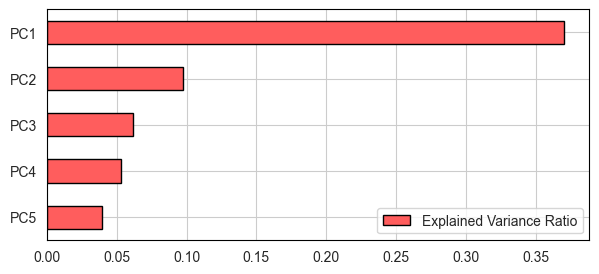

In [185]:
pca.explained_variance_ratio.iloc[::-1].plot.barh(
    figsize=(7, 3),
    edgecolor='k',
    color='#FF5D5D'
)
plt.xticks(rotation=0)
plt.legend(['Explained Variance Ratio']);

In [186]:
pca.fit(y_test)

test_pca = pca.transformed

test_pca.head(3)

,PC1,PC2,PC3,PC4,PC5
2015-10-11,0.002072,-0.000152,0.000373,-0.000117,-0.000092
2015-10-12,0.007795,0.038101,0.014610,0.007225,-0.001453
2015-10-13,0.054578,0.002302,0.016448,0.007518,0.000145


In [188]:
X_train_imputed

,GDP,FEDFUNDS,UNRATE,CIVPART,PSAVERT
2000-01-03,10247.720,5.73,4.1,67.3,4.5
2000-01-04,10247.720,5.73,4.1,67.3,4.5
2000-01-05,10247.720,5.73,4.1,67.3,4.5
2000-01-06,10247.720,5.73,4.1,67.3,4.5
2000-01-07,10247.720,5.73,4.1,67.3,4.5
...,...,...,...,...,...
2015-10-06,18332.079,0.12,5.0,62.5,7.5
2015-10-07,18332.079,0.12,5.0,62.5,7.5
2015-10-08,18332.079,0.12,5.0,62.5,7.5
2015-10-09,18332.079,0.12,5.0,62.5,7.5
